In [74]:
import seaborn as sns

In [75]:
import numpy as np

In [1]:
from numpy import expand_dims, clip, squeeze
from PIL.Image import fromarray
from random import randint

import tensorflow as tf
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.applications.vgg19 import VGG19
from tensorflow.python.keras.applications.vgg19 import preprocess_input
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array

In [68]:

class NeuralStyleTransfer(object):

    def __init__(self, content_img, style_img):
        self.content_img = self.load_and_process_image(content_img)
        self.style_img = self.load_and_process_image(style_img)
        self.generated_images = []
        self.best_img = None
        self.initialize_models_and_layers()
        self.set_paramers_and_hyper_parameters()

    def set_paramers_and_hyper_parameters(self, iterations=2, alpha=10., beta=20., lr=0.01):
        self.iterations = iterations
        self.alpha = alpha
        self.beta = beta
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        self.lam = 1. / len(self.style_models)

    def initialize_models_and_layers(self):
        self.model = VGG19(include_top=False, weights='imagenet')
        self.model.trainable = False
        self.style_layers = ['block1_conv1', 'block3_conv1', 'block5_conv1']
        # self.style_layers = ['block5_conv1']
        self.content_layer = 'block5_conv2'
        self.content_model = Model(inputs=self.model.input,
                                   outputs=self.model.get_layer(self.content_layer).output)
        self.style_models = [Model(inputs=self.model.input,
                                   outputs=self.model.get_layer(layer).output) for layer in self.style_layers]

    def load_and_process_image(self, image_path):
        img = load_img(image_path, target_size=(224, 224))
        img = img_to_array(img)
        img = preprocess_input(img)
        img = expand_dims(img, axis=0)
        return img

    def deprocess(self, x):
        x[:, :, 0] += 103.939
        x[:, :, 1] += 116.779
        x[:, :, 2] += 123.68
        x = x[:, :, ::-1]
        x = clip(x, 0, 255).astype('uint8')
        return x

    def save_image(self, image):
        if len(image.shape) == 4:
            img = squeeze(image, axis=0)
        img = self.deprocess(img)
        im = fromarray(img)
        filename = "final" + str(randint(10001, 999999)) + ".png"
        im.save('./static/'+filename)
        return filename

    def content_cost(self, content, generated):
        a_C = self.content_model(content)
        a_G = self.content_model(generated)
        cost = tf.reduce_mean(tf.square(a_C - a_G))
        return cost

    def calculate_gram_matrix(self, A):
        channels = int(A.shape[-1])
        a = tf.reshape(A, [-1, channels])
        n = tf.shape(a)[0]
        gram = tf.matmul(a, a, transpose_a=True)
        return gram / tf.cast(n, tf.float32)

    def style_cost(self, style, generated):
        J_style = 0
        for style_model in self.style_models:
            a_S = style_model(style)
            a_G = style_model(generated)
            GS = self.calculate_gram_matrix(a_S)
            GG = self.calculate_gram_matrix(a_G)
            current_cost = tf.reduce_mean(tf.square(GS - GG))
            J_style += current_cost * self.lam
        return J_style

    def train(self):
        
        generated = tf.Variable(self.content_img, dtype=tf.float32)
        best_cost = 1e12+0.1
        is_training = True
        
        for i in range(self.iterations):

            with tf.GradientTape() as tape:
                J_content = self.content_cost(self.content_img, generated)
                J_style = self.style_cost(self.style_img, generated)
                J_total = self.alpha * J_content + self.beta * J_style

            grads = tape.gradient(J_total, generated)
            self.optimizer.apply_gradients([(grads, generated)])

            print(f"J_total: {J_total}")
            if J_total < best_cost:
                best_cost = J_total
                self.best_image = generated.numpy()

            self.generated_images.append(generated.numpy())
            yield J_total, is_training
            
        is_training = False
        yield self.best_image, is_training

In [69]:
nst = NeuralStyleTransfer("./static/content.jpg", "./static/style.jpg" )

In [70]:
iterations = 50

In [71]:
nst.set_paramers_and_hyper_parameters(iterations, alpha=10., beta=20., lr=3.14)

In [72]:
cost = []

In [73]:
for val, is_training in nst.train():
    if is_training: cost.append(val)
    else:
        fname = nst.save_image(val)
        print(fname)

J_total: 13733986304.0
J_total: 10889334784.0
J_total: 8328617984.0
J_total: 6370275328.0
J_total: 5083037696.0
J_total: 4324132864.0
J_total: 3813856768.0
J_total: 3373636864.0
J_total: 2981816576.0
J_total: 2667971328.0
J_total: 2441682944.0
J_total: 2275280896.0
J_total: 2133378944.0
J_total: 1994871552.0
J_total: 1858796800.0
J_total: 1732075392.0
J_total: 1620399616.0
J_total: 1523319808.0
J_total: 1435952640.0
J_total: 1353533440.0
J_total: 1274359680.0
J_total: 1200010112.0
J_total: 1132787968.0
J_total: 1073885952.0
J_total: 1021899584.0
J_total: 975234048.0
J_total: 932923648.0
J_total: 894302784.0
J_total: 858724032.0
J_total: 825589888.0
J_total: 794075072.0
J_total: 763812736.0
J_total: 735404864.0
J_total: 709392512.0
J_total: 685638528.0
J_total: 663613056.0
J_total: 642815296.0
J_total: 623068416.0
J_total: 604534912.0
J_total: 587208000.0
J_total: 570816832.0
J_total: 555030464.0
J_total: 539839488.0
J_total: 525492608.0
J_total: 512094624.0
J_total: 499537792.0
J_total

In [76]:
cost = [cst.numpy() for cst in cost]

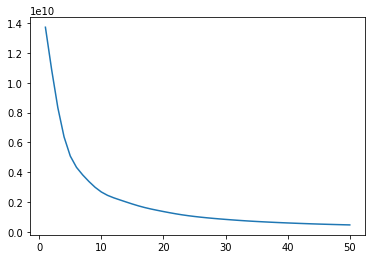

In [77]:
sns.lineplot(np.arange(1,iterations+1),cost)